<a href="https://colab.research.google.com/github/hphp777/GAN/blob/master/Basic/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("./mount")

Mounted at ./mount


In [ ]:
class MnistDataset(Dataset):
  
  def __init__(self, csv_file):
    # 데이터를 가공하는 과정
    self.data_df = pandas.read_csv(csv_file, header=None)
    # self.data_df = self.data_df.fillna(0)
    
    self.data_df = self.data_df.drop(columns=0, axis=1)
    # self.data_df = self.data_df.astype({1: 'int'})
    
    self.data_df = self.data_df.drop(index=0, axis=0)
    # for col in self.data_df.columns:
    #   self.data_df = self.data_df.astype({col: 'float'})
    # for i in range(1,29):
    #   for j in range(1,29):
    #     name = str(i) + 'x' + str(j)
    #     self.data_df = self.data_df.astype({name: 'float'})
    pass
  
  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1
    #0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation=None, cmap='Blues')
    pass

  pass

In [ ]:
# load dataset
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_train.csv')

In [ ]:
# 수정된 파일을 저장
# mnist_dataset.data_df.to_csv('mount/My Drive/Colab Notebooks/myo_gan/mnist_train.csv')

In [ ]:
# mnist dataset의 이미지 갯수
len(mnist_dataset)

12043

In [ ]:
# 2차원 이미지가 1차원으로 펼쳐진 형태
mnist_dataset.data_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
1,0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,...,745.0,746.0,747.0,748.0,749.0,750.0,751.0,752.0,753.0,754.0,755.0,756.0,757.0,758.0,759.0,760.0,761.0,762.0,763.0,764.0,765.0,766.0,767.0,768.0,769.0,770.0,771.0,772.0,773.0,774.0,775.0,776.0,777.0,778.0,779.0,780.0,781.0,782.0,783.0,784.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


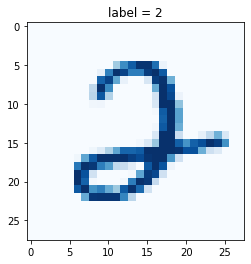

In [ ]:
mnist_dataset.plot_image(17)

# Discriminator

In [ ]:
# 1010과 다른점은 신경망의 크기
class Discriminator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,1),
        nn.Sigmoid()
    )

    #손실함수 설정: 평균제곱 오차 함수
    self.loss_function = nn.MSELoss()

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    
    #신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass
    if self.counter % 10000 == 0:
      print("counter = ", self.counter)
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    pass

In [ ]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [ ]:
%%time
# 판별기 테스트하기

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  # 실제 데이터
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
CPU times: user 53.6 s, sys: 840 ms, total: 54.4 s
Wall time: 54.7 s


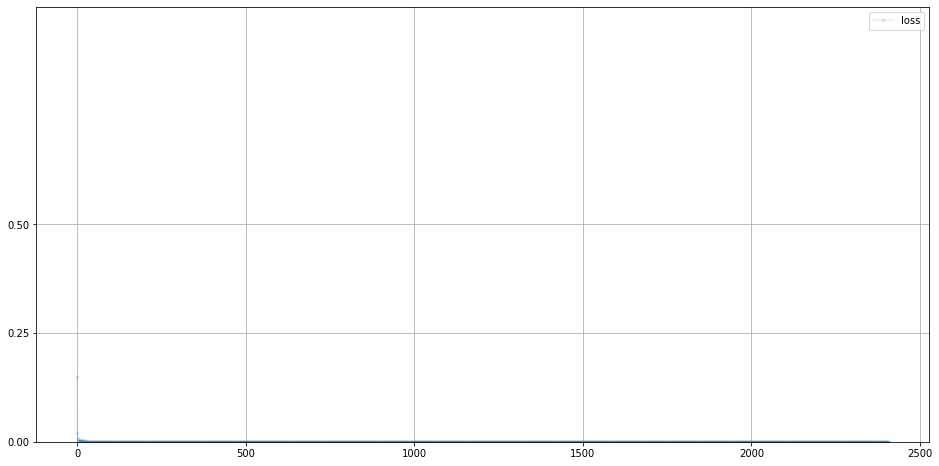

In [ ]:
D.plot_progress()

In [ ]:
# 임의로 선택한 이미지를 넣어 수동으로 확인 해 보자. 일부 이미지는 의도적으로 임의의 노이즈를 사용하였다.
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,10000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

# => 실제 이미지들은 출력값이 높으며 판별기가 진짜와 가짜의 이미지를 잘 구분한다는 것을 알 수 있다.

0.9999841451644897
0.9999163150787354
0.9999754428863525
0.9999701976776123
3.410844146856107e-05
3.891882442985661e-05
2.6115170840057544e-05
3.504777487250976e-05


# Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 손실함수는 오직 판별기에만 적용이 되기 때문에 생성기에서는 필요가 없다.

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    
    #신경망 출력 계산
    g_output = self.forward(inputs)

    #판별기로 전달
    d_output = D.forward(g_output)

    #손실 계산
    loss = D.loss_function(d_output,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass  

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    pass

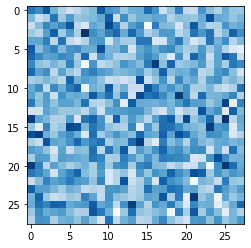

In [ ]:
# 생성기 결과 확인하기
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation=None, cmap='Blues')

# Training GAN

In [ ]:
%%time

D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련

for label, image_data_tensor, target_tensor in mnist_dataset:
  # 1단계: 참에 대해 판별기 훈련 
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 두개가 경쟁적으로 학습한다.

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detatch 함수를 이용
  # 가짜 데이터에 대해 결과가 0이 나와야 잘한것(속지 않은 것)
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  # 판별기와 반대로 결과가 1이 나와야 잘한것(속인것)
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

  pass

counter =  10000
counter =  20000
CPU times: user 1min 22s, sys: 1.37 s, total: 1min 24s
Wall time: 1min 23s


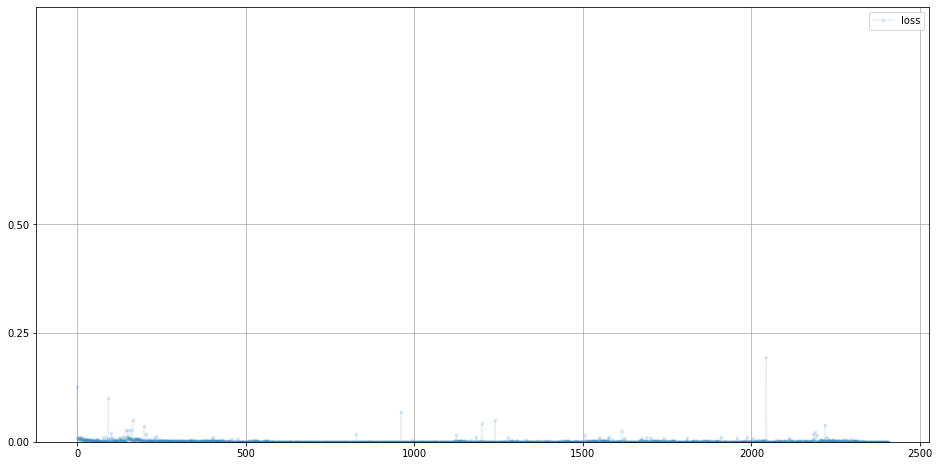

In [ ]:
D.plot_progress()

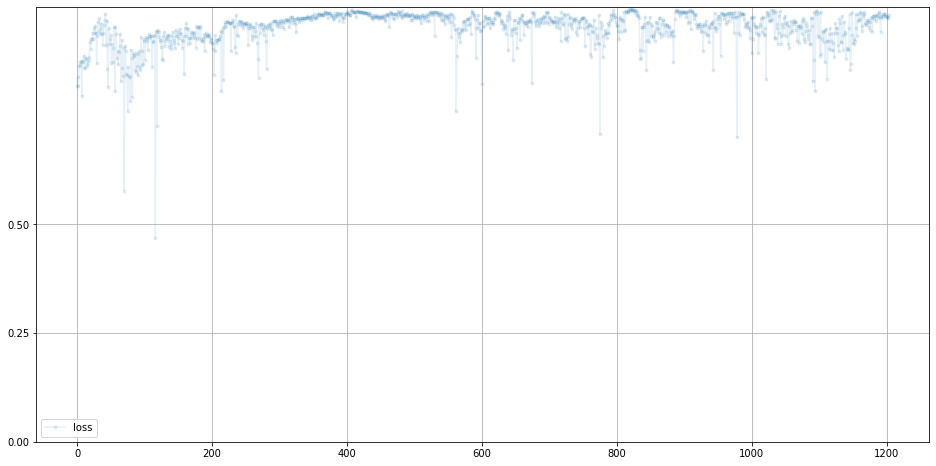

In [ ]:
G.plot_progress()

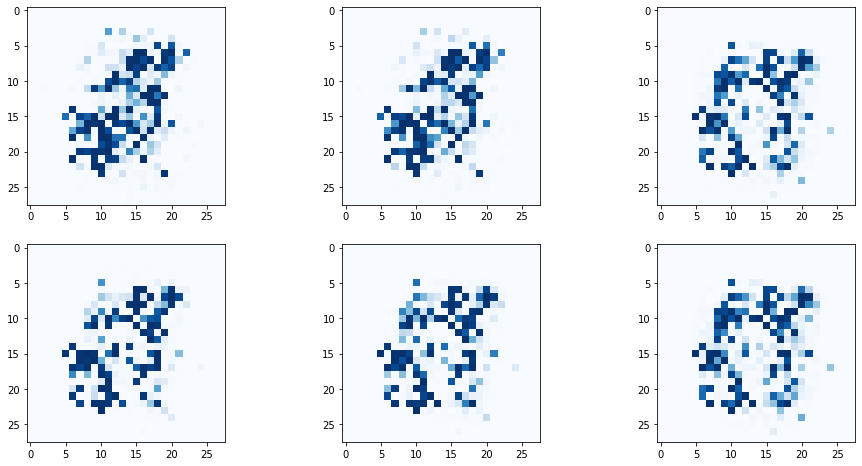

In [ ]:
# 생성기가 만들어내는 이미지 출력하기
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = None, cmap = 'Blues')
    pass
  pass

  # 처음과 달리 생성된 이미지에 특정한 형태가 존재하는 것을 확인할 수 있다.
  # 하지만 모든 이미지가 거의 똑같이 생긴것을 확인할 수 있는데 이는 GAN에서 자주 맞닥뜨리는 '모드붕괴'라는 현상으로, 해결이 필요하다.
  # 아직까지 이 문제에 대한 명확한 해결은 연구중으로 알려져 있다.

# 성능 향상

(1) 생성기의 seed를 100개로 다양하게 늘리기

In [ ]:
# 생성기에 투입되는 seed를 100개의 random한 정수로 바꾸어준다.
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [ ]:
# 1010과 다른점은 신경망의 크기
class Discriminator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,1),
        nn.Sigmoid()
    )

    #손실함수 설정: 평균제곱 오차 함수
    self.loss_function = nn.MSELoss()

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    
    #신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass
    if self.counter % 10000 == 0:
      print("counter = ", self.counter)
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # 손실함수는 오직 판별기에만 적용이 되기 때문에 생성기에서는 필요가 없다.

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    
    #신경망 출력 계산
    g_output = self.forward(inputs)

    #판별기로 전달
    d_output = D.forward(g_output)

    #손실 계산
    loss = D.loss_function(d_output,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass  

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass

In [ ]:
%%time

D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련

for label, image_data_tensor, target_tensor in mnist_dataset:
  # 1단계: 참에 대해 판별기 훈련 
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 두개가 경쟁적으로 학습한다.

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detatch 함수를 이용
  # 가짜 데이터에 대해 결과가 0이 나와야 잘한것(속지 않은 것)
  D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  # 판별기와 반대로 결과가 1이 나와야 잘한것(속인것)
  G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

  pass

counter =  10000
counter =  20000
CPU times: user 1min 24s, sys: 1.26 s, total: 1min 26s
Wall time: 1min 25s


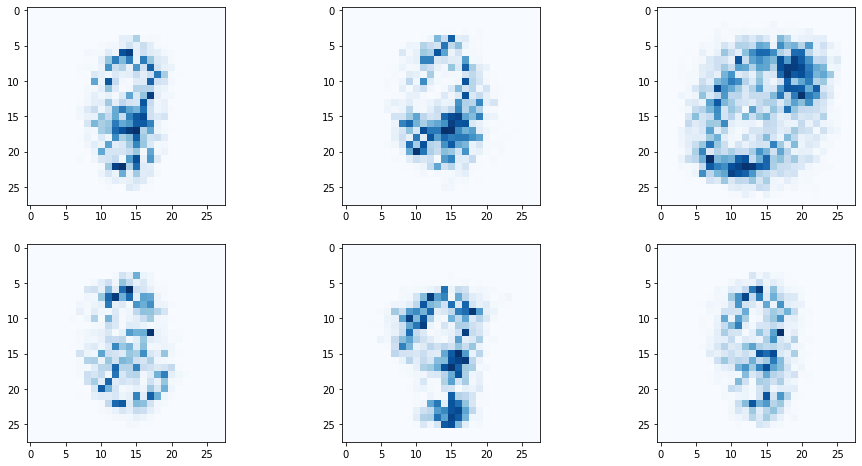

In [ ]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = None, cmap = 'Blues')
    pass
  pass
# 아까보다 이미지의 퀄리티가 좀더 향상되고, 좀더 다양한 느낌의 이미지가 형성되었다는 것을 확인 할 수 있다.

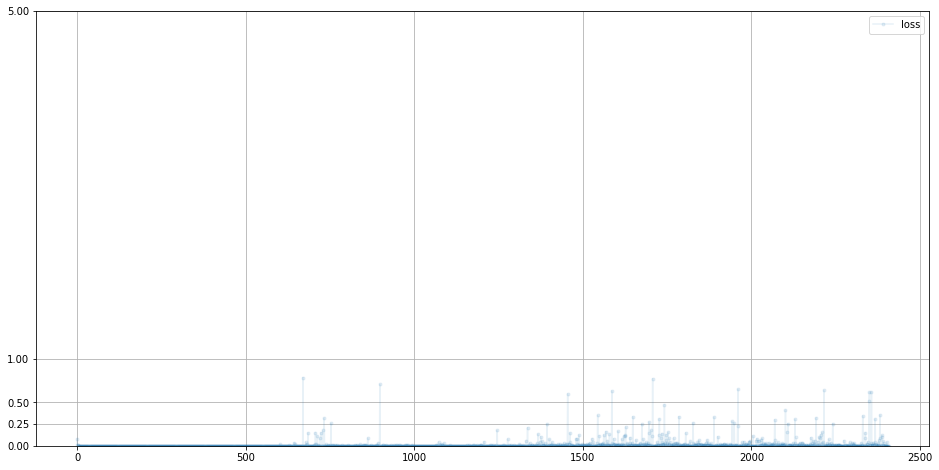

In [ ]:
D.plot_progress()

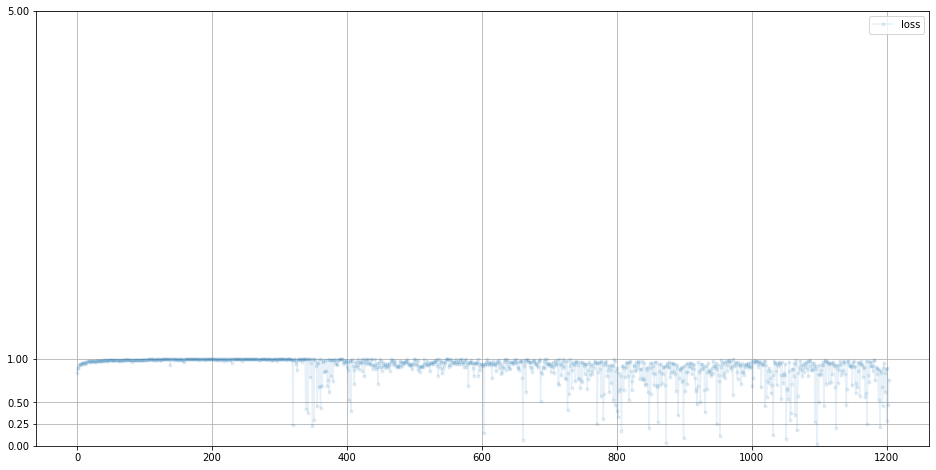

In [ ]:
G.plot_progress()

In [ ]:
# 둘다 손실값이 불규칙하게 분포하는 것을 확인 할 수 있다. 
# 이는 판별기와 생성기 사이의 균형이 맞춰지지 않았다는 것을 의미한다.

(2) 에포크를 늘리기

In [ ]:
%%time

D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련
for i in range(4):
  for label, image_data_tensor, target_tensor in mnist_dataset:
    # 1단계: 참에 대해 판별기 훈련 
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 두개가 경쟁적으로 학습한다.

    # 2단계: 거짓에 대해 판별기 훈련
    # G의 기울기가 계산되지 않도록 detatch 함수를 이용
    # 가짜 데이터에 대해 결과가 0이 나와야 잘한것(속지 않은 것)
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    # 3단계: 생성기 훈련
    # 판별기와 반대로 결과가 1이 나와야 잘한것(속인것)
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
CPU times: user 5min 38s, sys: 5.18 s, total: 5min 43s
Wall time: 5min 42s


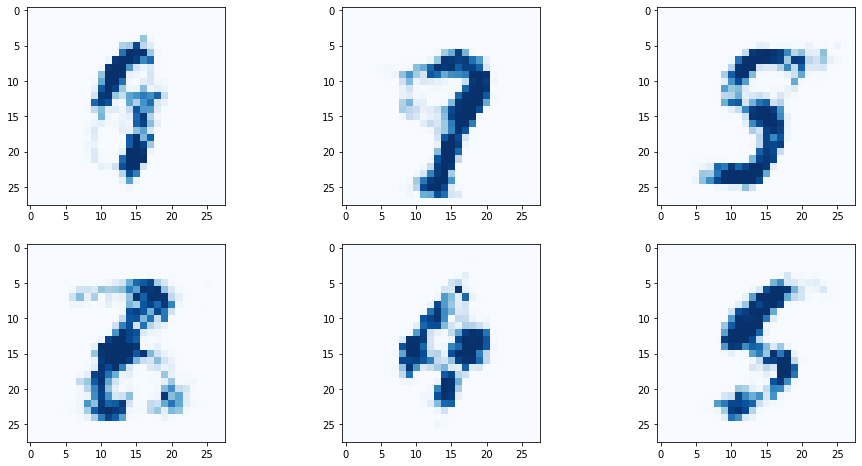

In [ ]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = None, cmap = 'Blues')
    pass
  pass
  # 아까보다 뚜렷하고 훨씬 다양한 형태의 이미지가 생성되는 것을 확인할 수 있다.

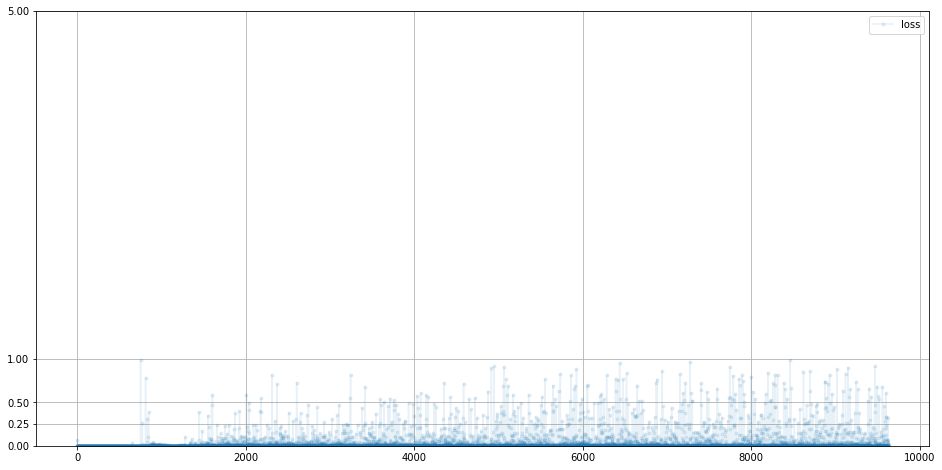

In [ ]:
D.plot_progress()

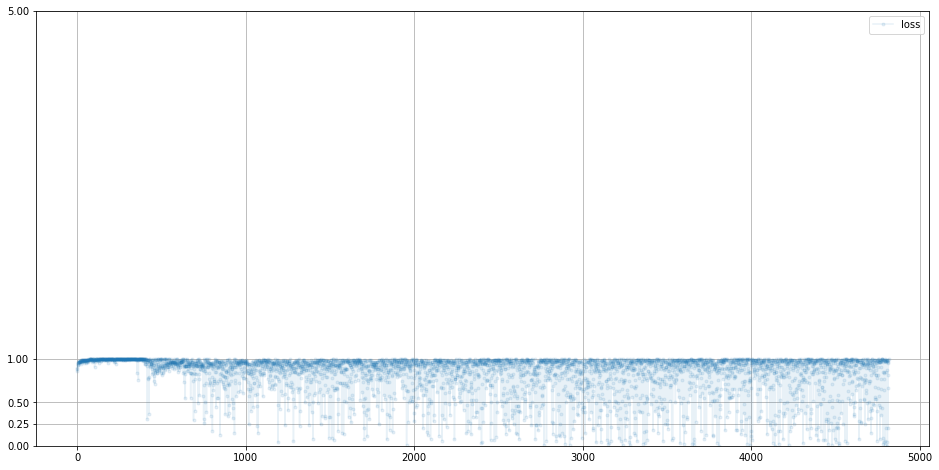

In [ ]:
G.plot_progress()

# 시드로 실험하기

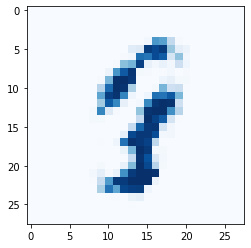

In [ ]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation = 'none', cmap = 'Blues')

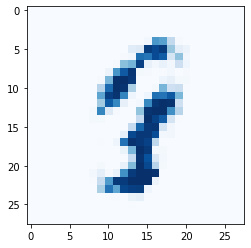

In [ ]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out1.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation = 'none', cmap = 'Blues')

seed1과 seed2사의의 일정한 각격의 12개의 seed를 구하는 코드를 작성해보자

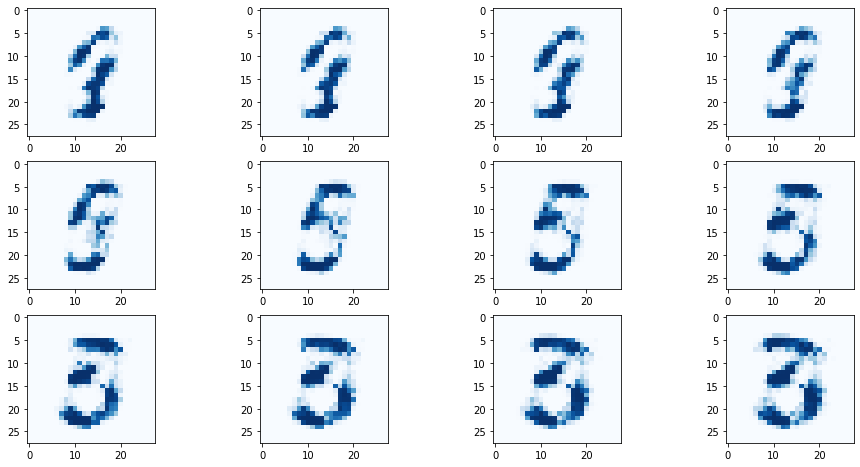

In [ ]:
count = 0

# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(3, 4, figsize = (16, 8))
for i in range(3):
  for j in range(4):
    seed = seed1 + (seed2 - seed1)/11 * count
    output = G.forward(seed)
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = None, cmap = 'Blues')
    count += 1
    pass
  pass

  # 시드가 변화함에 따라 이미지의 형태가 일정한 방향으로 진화 해 나가는 것을 확인할 수 있다. 
  # 이 밖에도, 시드를 더하면 두 이미지를 합친것 같은 형태가 출력되는 것을 확인할 수 있지만
  # 두 시드의 차를 대입해준다고 해서 이미지에서 겹치는 부분을 뺀 부분이 출력되지는 않는다.
  # 이를 통해 시드가 굉장히 복잡한 역할을 한다는 것을 확인 할 수 있다. 

  # conclusion
  # GAN을 설계하기 위한 가장 좋은 시작점은 생성기와 판별기를 동일한 구조로 설계하여 어느 한 쪽의 성능이 지나치게 좋아지지 않도록 하는 것이다.
  # 이진 교차 엔트로피의 경우는 0.69 (ln2)정도의 손실 값이 가장 이상적이다.
  # 모드붕괴를 해결하는 방법은 현재도 활발히 연구중인 분야이다,